# Denoising Autoencoders 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import io 

%load_ext tensorboard

## Generate training data 

We start by a practice run with some toy data, a quadratic curve with Gaussian noise. The model will be trained to remove this noise and recover the true population parabola.

In [2]:
num_samples = 10000
noise_std = 0.05 

def get_data(num_samples):
    """
    Draw circle with radius 0.5
    """
    
    scale = np.pi*np.linspace(-1, 1, num_samples)
    x1 = np.cos(scale)
    x2 = np.sin(scale)
    
    return np.stack([x1, x2], axis=1)*0.5

X = get_data(num_samples)
X_noisy = X + np.random.randn(*X.shape)*noise_std

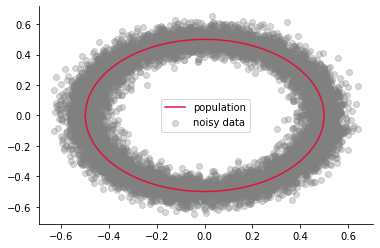

In [3]:
plt.figure()
plt.scatter(X_noisy[:, 0], X_noisy[:, 1], c='gray', alpha=0.3, label="noisy data")
plt.plot(X[:, 0], X[:, 1], c="crimson", label="population")
plt.legend()
sns.despine()
plt.show()

## Modeling

Our denoising autoencoder class DAE combines an encoder and decoder and a custom training step. The latter takes the target parabola, adds noise, feeds this through the encoder/decoder to approximate the target and calculates the reconstruction loss.

In [4]:
class DAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(DAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, data):
        z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        return reconstruction
    
         
    def test_step(self, data):
        z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
        
        return {
            "loss/reconstruction_loss": reconstruction_loss,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            noise = tf.random.normal(tf.shape(data), mean=0, stddev=noise_std)
            noisy_data = data + noise
            
            z = self.encoder(noisy_data)
            reconstruction = self.decoder(z)
                        
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            ) 
            
        # calculate gradients     
        grads = tape.gradient(reconstruction_loss, self.trainable_weights)
        
        # update the weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return  {
            "loss/reconstruction_loss": reconstruction_loss,
            "learning_rate": self.optimizer.lr,
        }

Our autoencoder model will be overcomplete i.e., it has the capacity to learn the identity function if no noise is added to the input. But adding the noise forces the model to learn a useful operation, to remove the noise from the input.

In [5]:
encoder = keras.Sequential(
    [layers.Dense(2, activation="relu"),
     layers.Dense(8, activation="relu"),
     layers.Dense(16, activation="relu"),]
)

decoder = keras.Sequential(
    [layers.Dense(8, activation="relu"),
     layers.Dense(2, activation="tanh")]
)

model = DAE(encoder, decoder)

model.compile(optimizer="adam")

During training, we will log the reconstruction loss on the training and some validation data, and also plot the reconstructions.

In [6]:
### LOGGING ###

# scalar callbacks
logdir = "denoising_logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# image callbacks - source: https://www.tensorflow.org/tensorboard/image_summaries
logdir = "denoising_logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + 'reconstruction/')

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image


def plot_reconstruction(data, preds, show=False):
    base = get_data(1000)
    figure = plt.figure()
    plt.scatter(data[:, 0], data[:, 1], c="gray", alpha=0.3, label="input") # model input
    plt.scatter(preds[:, 0], preds[:, 1], c="blue", alpha=0.5, label="prediction") # prediction
    plt.plot(base[:, 0], base[:, 1], c="crimson", label="population") # population

    plt.legend()
    plt.title("Denoising with an overcomplete autoencoder")
    sns.despine()
    
    if show:
        plt.show()
        
    return figure

def log_reconstruction(epoch, logs):
    reconstruction = model.predict(val_data)

    figure = plot_reconstruction(val_data, reconstruction)
    image = plot_to_image(figure)

    with file_writer.as_default():
        tf.summary.image("Reconstruction", image, step=epoch)

# Define the per-epoch callback.
reconstruction_plot_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_reconstruction)

In [7]:
# clean training data
train_data = X

# noisy validation data
base = get_data(1000)
val_data = base + np.random.randn(*base.shape)*noise_std

# train the model
history = model.fit(train_data,
                    epochs=20,
                    batch_size=32,
                    verbose=0,
                    validation_data=[val_data],   
                    callbacks=[tensorboard_callback, reconstruction_plot_callback],
               )

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Consider rewriting this model with the Functional API.


In [8]:
%tensorboard --logdir denoising_logs/

Reusing TensorBoard on port 6008 (pid 50360), started 0:58:57 ago. (Use '!kill 50360' to kill it.)

## Model evaluation

First, we evaluate our model with the same amount of noise added as in training:

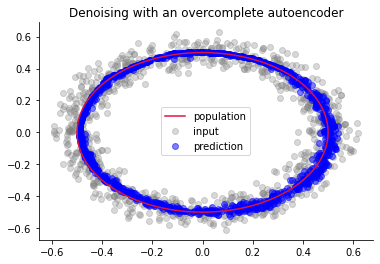

In [9]:
base = get_data(1000)
data = base + np.random.randn(*base.shape)*noise_std
preds = model.predict(data)

figure = plot_reconstruction(data, preds, show=True)

Now, with 5-times the amount of the original training noise:

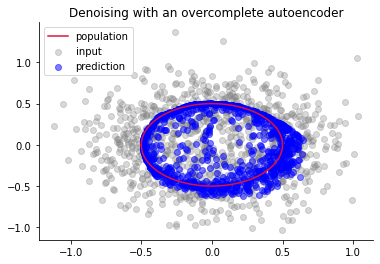

In [10]:
data = base + np.random.randn(*base.shape)*noise_std*5
preds = model.predict(data)

figure = plot_reconstruction(data, preds, show=True)

## Denoising vector field

We will now see how the model transforms the data space:

In [11]:
# set up a uniform grid
x = np.arange(-1, 1, 0.2)
y = np.arange(-1, 1, 0.2)
xx, yy = np.meshgrid(x, y, sparse=False)
grid_data = np.stack([xx, yy], axis=2)

# calculate the model predictions and deltas
grid_preds = model.predict(grid_data)
pred_delta = grid_preds - grid_data

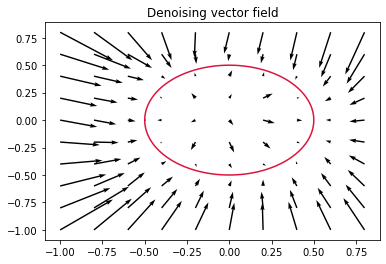

In [12]:
# plot the vector field
fig, ax = plt.subplots()
q = ax.quiver(xx, yy, pred_delta[:, :, 0], pred_delta[:, :, 1], units='xy', scale=2, width=0.01)
base = get_data(1000)
ax.plot(base[:, 0], base[:, 1], c="crimson")
plt.title("Denoising vector field")
plt.show()